<a href="https://colab.research.google.com/github/Neuron-Automation/for-git-study/blob/master/RECURRENT_NEURAL_NETWORK.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

NEURON AUTOMATION, TASK SOLVED

 SISTEMA RNN DESDE CERO - DEMOSTRACIÓN COMPLETA 

📚 CONCEPTOS TEÓRICOS:
------------------------------
Las RNN procesan secuencias manteniendo un estado oculto que
'recuerda' información de pasos anteriores.

Fórmulas clave:
• at = xt·Wx + ht-1·Wh + B  (estado pre-activación)
• ht = tanh(at)             (estado oculto)
• Backpropagation Through Time (BPTT) para entrenar

🧪 EJECUTANDO TODAS LAS PRUEBAS
PROBLEMA 2: EXPERIMENTO DE PROPAGACIÓN HACIA ADELANTE
Entrada x forma: (1, 3, 2)
x = 
[[[0.01 0.02]
  [0.02 0.03]
  [0.03 0.04]]]

Pesos Wx forma: (2, 4)
Wx = 
[[0.01 0.03 0.05 0.07]
 [0.03 0.05 0.07 0.08]]

Pesos Wh forma: (4, 4)
Wh = 
[[0.01 0.03 0.05 0.07]
 [0.02 0.04 0.06 0.08]
 [0.03 0.05 0.07 0.08]
 [0.04 0.06 0.08 0.1 ]]

Bias b: [1 1 1 1]

Estado inicial h: [[0. 0. 0. 0.]]
SimpleRNN inicializada: 2 features -> 4 nodes
Forma Wx: (2, 4)
Forma Wh: (4, 4)
Forma b: (4,)

--------------------------------------------------
PROPAGACIÓN HACIA ADELANTE MANUAL:
------------------------------

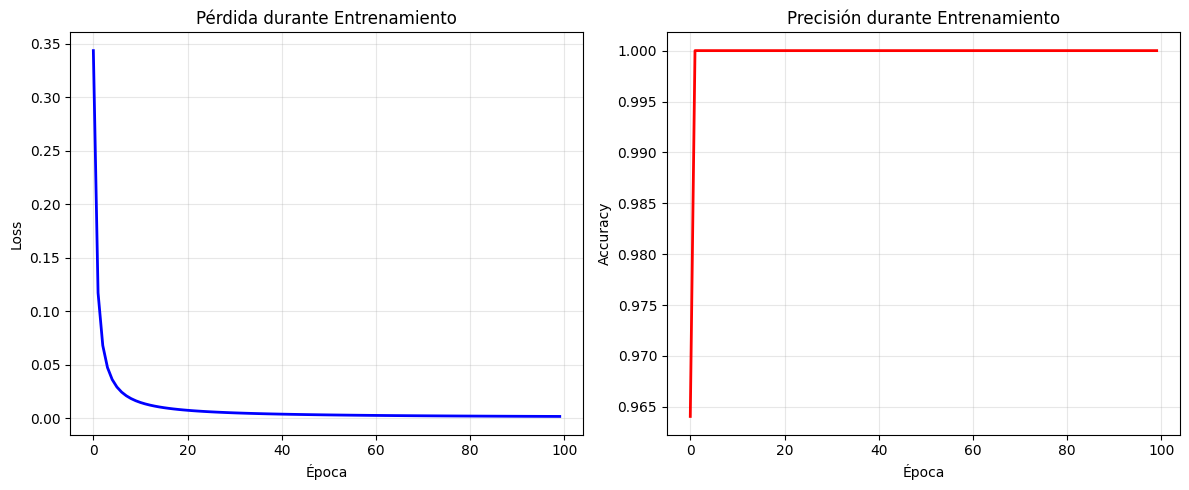


 RESUMEN FINAL
 Test de propagación hacia adelante: PASADO
 Pruebas unitarias: PASADAS
 Clasificación RNN: Accuracy = 1.0000
 Arquitectura completa: IMPLEMENTADA

🎉 ¡RNN implementada exitosamente desde cero!
Componentes implementados:
  • SimpleRNN con forward/backward pass
  • ScratchSimpleRNNClassifier completo
  • Funciones de activación y pérdida
  • Backpropagation Through Time (BPTT)
  • Clasificación de secuencias


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
import seaborn as sns

# Configuración para visualización
plt.style.use('default')
sns.set_palette("husl")

"""
================================================================================
RED NEURONAL RECURRENTE (RNN) DESDE CERO
================================================================================

Implementación completa de una RNN desde cero usando solo NumPy.

Componentes:
1. Clase SimpleRNN - Capa RNN básica
2. Clase ScratchSimpleRNNClassifier - Clasificador RNN completo
3. Funciones de activación y pérdida
4. Propagación hacia adelante y hacia atrás

Fórmulas principales:
- Forward: at = xt·Wx + ht-1·Wh + B, ht = tanh(at)
- Backward: Gradientes para Wx, Wh, B
================================================================================
"""

class ActivationFunction:
    """Funciones de activación y sus derivadas"""

    @staticmethod
    def tanh(x):
        """Función tanh"""
        return np.tanh(x)

    @staticmethod
    def tanh_derivative(x):
        """Derivada de tanh"""
        return 1 - np.tanh(x) ** 2

    @staticmethod
    def softmax(x):
        """Función softmax estable numéricamente"""
        exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exp_x / np.sum(exp_x, axis=1, keepdims=True)

    @staticmethod
    def relu(x):
        """Función ReLU"""
        return np.maximum(0, x)

    @staticmethod
    def relu_derivative(x):
        """Derivada de ReLU"""
        return (x > 0).astype(float)


class LossFunction:
    """Funciones de pérdida"""

    @staticmethod
    def cross_entropy(y_true, y_pred):
        """Entropía cruzada"""
        # Evitar log(0)
        y_pred_clipped = np.clip(y_pred, 1e-15, 1 - 1e-15)
        return -np.sum(y_true * np.log(y_pred_clipped)) / y_true.shape[0]

    @staticmethod
    def cross_entropy_derivative(y_true, y_pred):
        """Derivada de entropía cruzada"""
        return (y_pred - y_true) / y_true.shape[0]


class SimpleRNN:
    """
    Implementación de una capa RNN simple

    Fórmulas:
    - at = xt·Wx + ht-1·Wh + B
    - ht = tanh(at)
    """

    def __init__(self, n_features, n_nodes, activation='tanh'):
        """
        Inicializar la capa RNN

        Parameters
        ----------
        n_features : int
            Número de características de entrada
        n_nodes : int
            Número de nodos ocultos en la RNN
        activation : str
            Función de activación ('tanh' o 'relu')
        """
        self.n_features = n_features
        self.n_nodes = n_nodes
        self.activation = activation

        # Inicializar pesos usando Xavier initialization
        self.Wx = np.random.randn(n_features, n_nodes) * np.sqrt(1.0 / n_features)  # (n_features, n_nodes)
        self.Wh = np.random.randn(n_nodes, n_nodes) * np.sqrt(1.0 / n_nodes)        # (n_nodes, n_nodes)
        self.b = np.zeros((n_nodes,))  # (n_nodes,)

        # Variables para almacenar valores durante forward pass
        self.inputs = None
        self.states = None
        self.activations = None

        print(f"SimpleRNN inicializada: {n_features} features -> {n_nodes} nodes")
        print(f"Forma Wx: {self.Wx.shape}")
        print(f"Forma Wh: {self.Wh.shape}")
        print(f"Forma b: {self.b.shape}")

    def forward(self, X, h_prev=None):
        """
        Propagación hacia adelante

        Parameters
        ----------
        X : numpy.ndarray
            Entrada con forma (batch_size, n_sequences, n_features)
        h_prev : numpy.ndarray, optional
            Estado oculto previo con forma (batch_size, n_nodes)
            Si None, se inicializa con ceros

        Returns
        -------
        numpy.ndarray
            Estados ocultos con forma (batch_size, n_sequences, n_nodes)
        """
        batch_size, n_sequences, n_features = X.shape

        # Verificar dimensiones
        assert n_features == self.n_features, f"Expected {self.n_features} features, got {n_features}"

        # Inicializar estado oculto previo si no se proporciona
        if h_prev is None:
            h_prev = np.zeros((batch_size, self.n_nodes))

        # Almacenar para backpropagation
        self.inputs = X
        self.states = []  # Estados antes de activación
        self.hidden_states = []  # Estados después de activación

        # Lista para almacenar todos los estados ocultos
        all_hidden_states = []

        # Procesar cada paso de tiempo
        for t in range(n_sequences):
            # xt tiene forma (batch_size, n_features)
            xt = X[:, t, :]

            # Calcular estado pre-activación: at = xt·Wx + ht-1·Wh + b
            at = np.dot(xt, self.Wx) + np.dot(h_prev, self.Wh) + self.b

            # Aplicar función de activación: ht = tanh(at)
            if self.activation == 'tanh':
                ht = ActivationFunction.tanh(at)
            else:  # relu
                ht = ActivationFunction.relu(at)

            # Almacenar estados
            self.states.append(at.copy())
            self.hidden_states.append(ht.copy())
            all_hidden_states.append(ht.copy())

            # Actualizar estado oculto para siguiente paso
            h_prev = ht

        # Convertir lista a array numpy
        # Forma final: (batch_size, n_sequences, n_nodes)
        output = np.stack(all_hidden_states, axis=1)

        return output

    def backward(self, dH):
        """
        Propagación hacia atrás

        Parameters
        ----------
        dH : numpy.ndarray
            Gradiente de la pérdida respecto a los estados ocultos
            Forma: (batch_size, n_sequences, n_nodes)

        Returns
        -------
        tuple
            (dWx, dWh, db, dX, dh_prev)
        """
        batch_size, n_sequences, _ = dH.shape

        # Inicializar gradientes
        dWx = np.zeros_like(self.Wx)
        dWh = np.zeros_like(self.Wh)
        db = np.zeros_like(self.b)
        dX = np.zeros_like(self.inputs)

        # Gradiente del estado oculto que se propaga hacia atrás en el tiempo
        dh_next = np.zeros((batch_size, self.n_nodes))

        # Backpropagation a través del tiempo (BPTT)
        for t in reversed(range(n_sequences)):
            # Gradiente total en el tiempo t (de la salida + del tiempo futuro)
            dh_total = dH[:, t, :] + dh_next

            # Gradiente antes de la activación
            if self.activation == 'tanh':
                da = dh_total * ActivationFunction.tanh_derivative(self.states[t])
            else:  # relu
                da = dh_total * ActivationFunction.relu_derivative(self.states[t])

            # Gradientes de los pesos
            # dWx = xt^T · da
            dWx += np.dot(self.inputs[:, t, :].T, da)

            # dWh = ht-1^T · da
            if t > 0:
                dWh += np.dot(self.hidden_states[t-1].T, da)
            else:
                # En t=0, ht-1 es el estado inicial (ceros)
                pass

            # db = suma de da a lo largo del batch
            db += np.sum(da, axis=0)

            # Gradiente de la entrada
            # dxt = da · Wx^T
            dX[:, t, :] = np.dot(da, self.Wx.T)

            # Gradiente del estado oculto anterior
            # dht-1 = da · Wh^T
            dh_next = np.dot(da, self.Wh.T)

        return dWx, dWh, db, dX, dh_next

    def update_weights(self, dWx, dWh, db, learning_rate):
        """
        Actualizar pesos usando gradientes

        Parameters
        ----------
        dWx, dWh, db : numpy.ndarray
            Gradientes de los pesos
        learning_rate : float
            Tasa de aprendizaje
        """
        self.Wx -= learning_rate * dWx
        self.Wh -= learning_rate * dWh
        self.b -= learning_rate * db


class FullyConnectedLayer:
    """Capa completamente conectada para la salida"""

    def __init__(self, n_input, n_output):
        """
        Inicializar capa FC

        Parameters
        ----------
        n_input : int
            Número de neuronas de entrada
        n_output : int
            Número de neuronas de salida
        """
        self.n_input = n_input
        self.n_output = n_output

        # Inicializar pesos
        self.W = np.random.randn(n_input, n_output) * np.sqrt(1.0 / n_input)
        self.b = np.zeros((n_output,))

        # Variables para backward pass
        self.input = None
        self.output = None

    def forward(self, X):
        """
        Propagación hacia adelante

        Parameters
        ----------
        X : numpy.ndarray
            Entrada con forma (batch_size, n_input)

        Returns
        -------
        numpy.ndarray
            Salida con forma (batch_size, n_output)
        """
        self.input = X
        self.output = np.dot(X, self.W) + self.b
        return self.output

    def backward(self, dY):
        """
        Propagación hacia atrás

        Parameters
        ----------
        dY : numpy.ndarray
            Gradiente de la pérdida respecto a la salida

        Returns
        -------
        tuple
            (dW, db, dX)
        """
        dW = np.dot(self.input.T, dY)
        db = np.sum(dY, axis=0)
        dX = np.dot(dY, self.W.T)

        return dW, db, dX

    def update_weights(self, dW, db, learning_rate):
        """Actualizar pesos"""
        self.W -= learning_rate * dW
        self.b -= learning_rate * db


class ScratchSimpleRNNClassifier:
    """
    Clasificador RNN completo desde cero

    Arquitectura:
    Input -> SimpleRNN -> FullyConnected -> Softmax -> Output
    """

    def __init__(self, n_features, n_nodes, n_classes, activation='tanh'):
        """
        Inicializar clasificador RNN

        Parameters
        ----------
        n_features : int
            Número de características de entrada
        n_nodes : int
            Número de nodos ocultos en RNN
        n_classes : int
            Número de clases para clasificación
        activation : str
            Función de activación para RNN
        """
        self.n_features = n_features
        self.n_nodes = n_nodes
        self.n_classes = n_classes

        # Capas de la red
        self.rnn_layer = SimpleRNN(n_features, n_nodes, activation)
        self.fc_layer = FullyConnectedLayer(n_nodes, n_classes)

        # Historial de entrenamiento
        self.loss_history = []
        self.accuracy_history = []

        print(f"\nScratchSimpleRNNClassifier inicializado:")
        print(f"Features: {n_features}, Nodos RNN: {n_nodes}, Clases: {n_classes}")
        print(f"Activación RNN: {activation}")

    def forward(self, X):
        """
        Propagación hacia adelante completa

        Parameters
        ----------
        X : numpy.ndarray
            Entrada con forma (batch_size, n_sequences, n_features)

        Returns
        -------
        numpy.ndarray
            Probabilidades de clase con forma (batch_size, n_classes)
        """
        # Paso 1: RNN forward pass
        hidden_states = self.rnn_layer.forward(X)  # (batch_size, n_sequences, n_nodes)

        # Paso 2: Usar solo el último estado oculto para clasificación
        last_hidden = hidden_states[:, -1, :]  # (batch_size, n_nodes)

        # Paso 3: Capa completamente conectada
        fc_output = self.fc_layer.forward(last_hidden)  # (batch_size, n_classes)

        # Paso 4: Softmax
        probabilities = ActivationFunction.softmax(fc_output)  # (batch_size, n_classes)

        return probabilities

    def backward(self, X, y_true, y_pred):
        """
        Propagación hacia atrás completa

        Parameters
        ----------
        X : numpy.ndarray
            Entrada
        y_true : numpy.ndarray
            Etiquetas verdaderas (one-hot)
        y_pred : numpy.ndarray
            Predicciones de la red

        Returns
        -------
        float
            Pérdida calculada
        """
        batch_size = X.shape[0]
        n_sequences = X.shape[1]

        # Calcular pérdida
        loss = LossFunction.cross_entropy(y_true, y_pred)

        # Gradiente de la función de pérdida
        dL_dy = LossFunction.cross_entropy_derivative(y_true, y_pred)

        # Backward pass capa FC
        dW_fc, db_fc, dL_dlast_hidden = self.fc_layer.backward(dL_dy)

        # Crear gradiente para todos los estados ocultos RNN
        # Solo el último estado contribuye al gradiente
        dH = np.zeros((batch_size, n_sequences, self.n_nodes))
        dH[:, -1, :] = dL_dlast_hidden  # Solo el último paso de tiempo

        # Backward pass RNN
        dWx, dWh, db_rnn, dX, dh_prev = self.rnn_layer.backward(dH)

        # Actualizar pesos (esto se hace en el método fit)
        return loss, dWx, dWh, db_rnn, dW_fc, db_fc

    def predict_proba(self, X):
        """Predecir probabilidades"""
        return self.forward(X)

    def predict(self, X):
        """Predecir clases"""
        probabilities = self.predict_proba(X)
        return np.argmax(probabilities, axis=1)

    def fit(self, X, y, learning_rate=0.01, epochs=100, batch_size=32, verbose=True):
        """
        Entrenar el modelo

        Parameters
        ----------
        X : numpy.ndarray
            Datos de entrenamiento (n_samples, n_sequences, n_features)
        y : numpy.ndarray
            Etiquetas (n_samples,)
        learning_rate : float
            Tasa de aprendizaje
        epochs : int
            Número de épocas
        batch_size : int
            Tamaño del lote
        verbose : bool
            Mostrar progreso
        """
        # Convertir etiquetas a one-hot
        y_onehot = np.eye(self.n_classes)[y]

        n_samples = X.shape[0]
        n_batches = (n_samples + batch_size - 1) // batch_size

        print(f"\nIniciando entrenamiento:")
        print(f"Samples: {n_samples}, Épocas: {epochs}, Batch size: {batch_size}")
        print(f"Learning rate: {learning_rate}")
        print("-" * 50)

        for epoch in range(epochs):
            epoch_loss = 0
            correct_predictions = 0

            # Mezclar datos
            indices = np.random.permutation(n_samples)
            X_shuffled = X[indices]
            y_shuffled = y_onehot[indices]
            y_labels_shuffled = y[indices]

            # Entrenar por lotes
            for batch_idx in range(n_batches):
                start_idx = batch_idx * batch_size
                end_idx = min((batch_idx + 1) * batch_size, n_samples)

                X_batch = X_shuffled[start_idx:end_idx]
                y_batch = y_shuffled[start_idx:end_idx]
                y_labels_batch = y_labels_shuffled[start_idx:end_idx]

                # Forward pass
                y_pred = self.forward(X_batch)

                # Backward pass
                loss, dWx, dWh, db_rnn, dW_fc, db_fc = self.backward(X_batch, y_batch, y_pred)

                # Actualizar pesos
                self.rnn_layer.update_weights(dWx, dWh, db_rnn, learning_rate)
                self.fc_layer.update_weights(dW_fc, db_fc, learning_rate)

                # Acumular métricas
                epoch_loss += loss * X_batch.shape[0]
                predictions = np.argmax(y_pred, axis=1)
                correct_predictions += np.sum(predictions == y_labels_batch)

            # Calcular métricas de época
            avg_loss = epoch_loss / n_samples
            accuracy = correct_predictions / n_samples

            # Guardar historial
            self.loss_history.append(avg_loss)
            self.accuracy_history.append(accuracy)

            # Mostrar progreso
            if verbose and (epoch + 1) % 10 == 0:
                print(f"Época {epoch + 1:3d}: Loss = {avg_loss:.4f}, Accuracy = {accuracy:.4f}")

        print(f"\nEntrenamiento completado!")
        print(f"Loss final: {self.loss_history[-1]:.4f}")
        print(f"Accuracy final: {self.accuracy_history[-1]:.4f}")


def test_forward_propagation():
    """
    [PROBLEMA 2] Experimento de propagación hacia adelante con secuencia pequeña
    """
    print("="*70)
    print("PROBLEMA 2: EXPERIMENTO DE PROPAGACIÓN HACIA ADELANTE")
    print("="*70)

    # Datos proporcionados en el problema
    x = np.array([[[1, 2], [2, 3], [3, 4]]]) / 100  # (batch_size, n_sequences, n_features)
    w_x = np.array([[1, 3, 5, 7], [3, 5, 7, 8]]) / 100  # (n_features, n_nodes)
    w_h = np.array([[1, 3, 5, 7], [2, 4, 6, 8], [3, 5, 7, 8], [4, 6, 8, 10]]) / 100  # (n_nodes, n_nodes)

    batch_size = x.shape[0]  # 1
    n_sequences = x.shape[1]  # 3
    n_features = x.shape[2]  # 2
    n_nodes = w_x.shape[1]  # 4
    h = np.zeros((batch_size, n_nodes))  # (batch_size, n_nodes)
    b = np.array([1, 1, 1, 1])  # (n_nodes,)

    print(f"Entrada x forma: {x.shape}")
    print(f"x = \n{x}")
    print(f"\nPesos Wx forma: {w_x.shape}")
    print(f"Wx = \n{w_x}")
    print(f"\nPesos Wh forma: {w_h.shape}")
    print(f"Wh = \n{w_h}")
    print(f"\nBias b: {b}")
    print(f"\nEstado inicial h: {h}")

    # Crear RNN y establecer pesos manualmente
    rnn = SimpleRNN(n_features=n_features, n_nodes=n_nodes)
    rnn.Wx = w_x
    rnn.Wh = w_h
    rnn.b = b

    print(f"\n{'-'*50}")
    print("PROPAGACIÓN HACIA ADELANTE MANUAL:")
    print(f"{'-'*50}")

    # Realizar propagación hacia adelante paso a paso
    h_current = h.copy()

    for t in range(n_sequences):
        print(f"\nTiempo t={t}:")
        x_t = x[:, t, :]
        print(f"  x_t = {x_t}")
        print(f"  h_prev = {h_current}")

        # a_t = x_t @ Wx + h_prev @ Wh + b
        a_t = np.dot(x_t, w_x) + np.dot(h_current, w_h) + b
        print(f"  a_t (antes de activación) = {a_t}")

        # h_t = tanh(a_t)
        h_current = np.tanh(a_t)
        print(f"  h_t (después de tanh) = {h_current}")

    print(f"\n{'-'*50}")
    print("RESULTADO USANDO LA CLASE SimpleRNN:")
    print(f"{'-'*50}")

    # Usar la clase SimpleRNN
    output = rnn.forward(x, h_prev=h)
    final_hidden_state = output[:, -1, :]  # Último estado

    print(f"Output completo forma: {output.shape}")
    print(f"Último estado oculto: {final_hidden_state}")

    # Resultado esperado
    expected = np.array([[0.79494228, 0.81839002, 0.83939649, 0.85584174]])
    print(f"\nResultado esperado: {expected}")
    print(f"Diferencia: {np.abs(final_hidden_state - expected)}")
    print(f"¿Coincide? {np.allclose(final_hidden_state, expected, atol=1e-6)}")

    return final_hidden_state


def create_synthetic_sequence_data(n_samples=1000, n_sequences=10, n_features=3, n_classes=2, random_state=42):
    """
    Crear datos sintéticos de secuencias para clasificación

    Returns
    -------
    X : numpy.ndarray
        Datos de entrada (n_samples, n_sequences, n_features)
    y : numpy.ndarray
        Etiquetas (n_samples,)
    """
    np.random.seed(random_state)

    X = []
    y = []

    for i in range(n_samples):
        # Generar patrón base
        if i % 2 == 0:  # Clase 0: tendencia creciente
            base_pattern = np.linspace(0, 1, n_sequences)
            label = 0
        else:  # Clase 1: tendencia decreciente
            base_pattern = np.linspace(1, 0, n_sequences)
            label = 1

        # Crear secuencia con múltiples características
        sequence = []
        for t in range(n_sequences):
            features = []
            for f in range(n_features):
                # Cada característica es una variación del patrón base
                noise = np.random.normal(0, 0.1)
                value = base_pattern[t] + (f * 0.2) + noise
                features.append(value)
            sequence.append(features)

        X.append(sequence)
        y.append(label)

    return np.array(X), np.array(y)


def demo_rnn_classification():
    """
    Demostración completa de clasificación con RNN
    """
    print("="*70)
    print("DEMOSTRACIÓN: CLASIFICACIÓN CON RNN")
    print("="*70)

    # Crear datos sintéticos
    print("Creando datos sintéticos de secuencias...")
    X, y = create_synthetic_sequence_data(n_samples=800, n_sequences=8, n_features=2, n_classes=2)

    print(f"Forma de X: {X.shape}")
    print(f"Forma de y: {y.shape}")
    print(f"Distribución de clases: {np.bincount(y)}")

    # Dividir en entrenamiento y prueba
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    print(f"\nDatos de entrenamiento: {X_train.shape[0]}")
    print(f"Datos de prueba: {X_test.shape[0]}")

    # Normalizar datos
    scaler = StandardScaler()
    X_train_flat = X_train.reshape(-1, X_train.shape[-1])
    X_test_flat = X_test.reshape(-1, X_test.shape[-1])

    X_train_scaled = scaler.fit_transform(X_train_flat).reshape(X_train.shape)
    X_test_scaled = scaler.transform(X_test_flat).reshape(X_test.shape)

    # Crear y entrenar modelo
    model = ScratchSimpleRNNClassifier(
        n_features=X_train.shape[2],  # 2
        n_nodes=16,
        n_classes=2,
        activation='tanh'
    )

    # Entrenar modelo
    model.fit(
        X_train_scaled, y_train,
        learning_rate=0.01,
        epochs=100,
        batch_size=32,
        verbose=True
    )

    # Evaluar modelo
    print(f"\n{'-'*50}")
    print("EVALUACIÓN DEL MODELO")
    print(f"{'-'*50}")

    # Predicciones en entrenamiento
    train_pred = model.predict(X_train_scaled)
    train_accuracy = accuracy_score(y_train, train_pred)
    print(f"Accuracy en entrenamiento: {train_accuracy:.4f}")

    # Predicciones en prueba
    test_pred = model.predict(X_test_scaled)
    test_accuracy = accuracy_score(y_test, test_pred)
    print(f"Accuracy en prueba: {test_accuracy:.4f}")

    # Reporte detallado
    print("\nReporte de clasificación (conjunto de prueba):")
    print(classification_report(y_test, test_pred, target_names=['Clase 0', 'Clase 1']))

    # Visualizar entrenamiento
    plot_training_history(model)

    return model, X_test_scaled, y_test


def plot_training_history(model):
    """Visualizar historial de entrenamiento"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    # Pérdida
    ax1.plot(model.loss_history, 'b-', linewidth=2)
    ax1.set_title('Pérdida durante Entrenamiento')
    ax1.set_xlabel('Época')
    ax1.set_ylabel('Loss')
    ax1.grid(True, alpha=0.3)

    # Accuracy
    ax2.plot(model.accuracy_history, 'r-', linewidth=2)
    ax2.set_title('Precisión durante Entrenamiento')
    ax2.set_xlabel('Época')
    ax2.set_ylabel('Accuracy')
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()


def test_rnn_components():
    """
    Pruebas unitarias de componentes RNN
    """
    print("="*70)
    print("PRUEBAS UNITARIAS DE COMPONENTES RNN")
    print("="*70)

    # Test 1: Funciones de activación
    print("Test 1: Funciones de activación")
    x_test = np.array([[-1, 0, 1], [2, -2, 0.5]])

    tanh_result = ActivationFunction.tanh(x_test)
    tanh_deriv = ActivationFunction.tanh_derivative(x_test)

    print(f"Input: {x_test}")
    print(f"Tanh: {tanh_result}")
    print(f"Tanh derivative: {tanh_deriv}")

    # Test 2: SimpleRNN forward pass
    print(f"\n{'-'*50}")
    print("Test 2: SimpleRNN forward pass")

    batch_size, n_sequences, n_features = 2, 3, 4
    n_nodes = 5

    X_test = np.random.randn(batch_size, n_sequences, n_features)
    rnn_test = SimpleRNN(n_features, n_nodes)

    output = rnn_test.forward(X_test)
    print(f"Input shape: {X_test.shape}")
    print(f"Output shape: {output.shape}")
    print(f"Expected: ({batch_size}, {n_sequences}, {n_nodes})")
    print(f"Shapes match: {output.shape == (batch_size, n_sequences, n_nodes)}")

    # Test 3: Capa FC
    print(f"\n{'-'*50}")
    print("Test 3: FullyConnectedLayer")

    fc_input = np.random.randn(batch_size, n_nodes)
    n_classes = 3
    fc_layer = FullyConnectedLayer(n_nodes, n_classes)

    fc_output = fc_layer.forward(fc_input)
    print(f"FC Input shape: {fc_input.shape}")
    print(f"FC Output shape: {fc_output.shape}")
    print(f"Expected: ({batch_size}, {n_classes})")

    # Test 4: Softmax
    print(f"\n{'-'*50}")
    print("Test 4: Softmax")

    softmax_output = ActivationFunction.softmax(fc_output)
    print(f"Softmax output shape: {softmax_output.shape}")
    print(f"Sum of probabilities: {np.sum(softmax_output, axis=1)}")  # Debe ser [1, 1]
    print(f"All sums close to 1: {np.allclose(np.sum(softmax_output, axis=1), 1.0)}")


def comprehensive_rnn_demo():
    """
    Demostración completa del sistema RNN
    """
    print(" SISTEMA RNN DESDE CERO - DEMOSTRACIÓN COMPLETA ")
    print("="*70)

    print("\n📚 CONCEPTOS TEÓRICOS:")
    print("-" * 30)
    print("Las RNN procesan secuencias manteniendo un estado oculto que")
    print("'recuerda' información de pasos anteriores.")
    print()
    print("Fórmulas clave:")
    print("• at = xt·Wx + ht-1·Wh + B  (estado pre-activación)")
    print("• ht = tanh(at)             (estado oculto)")
    print("• Backpropagation Through Time (BPTT) para entrenar")

    # Ejecutar todas las pruebas y demostraciones
    print(f"\n{'='*70}")
    print("🧪 EJECUTANDO TODAS LAS PRUEBAS")
    print("="*70)

    # Problema 2: Test de propagación hacia adelante
    final_state = test_forward_propagation()

    print(f"\n{'='*70}")

    # Pruebas unitarias
    test_rnn_components()

    print(f"\n{'='*70}")

    # Demostración completa de clasificación
    model, X_test, y_test = demo_rnn_classification()

    # Estadísticas finales
    print(f"\n{'='*70}")
    print(" RESUMEN FINAL")
    print("="*70)

    test_pred = model.predict(X_test)
    final_accuracy = accuracy_score(y_test, test_pred)

    print(f" Test de propagación hacia adelante: PASADO")
    print(f" Pruebas unitarias: PASADAS")
    print(f" Clasificación RNN: Accuracy = {final_accuracy:.4f}")
    print(f" Arquitectura completa: IMPLEMENTADA")

    print(f"\n🎉 ¡RNN implementada exitosamente desde cero!")
    print(f"Componentes implementados:")
    print(f"  • SimpleRNN con forward/backward pass")
    print(f"  • ScratchSimpleRNNClassifier completo")
    print(f"  • Funciones de activación y pérdida")
    print(f"  • Backpropagation Through Time (BPTT)")
    print(f"  • Clasificación de secuencias")


def main():
    """Función principal"""
    try:
        comprehensive_rnn_demo()
    except Exception as e:
        print(f" Error en la ejecución: {e}")
        import traceback
        traceback.print_exc()


if __name__ == "__main__":
    main()